# Distinguishing Traffic Signs

## Preparing image data

In [1]:
import numpy as np
import zipfile
import pprint

from skimage.transform import resize
from imageio import imread

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import (Flatten, Dense, Dropout)

Using TensorFlow backend.


In [3]:
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)

In [4]:
IMG_SIZE = 32
TEST_SIZE = 0.2

In [5]:
X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile(
          'GTSRB_Final_Training_Images.zip', 'r')
file_paths = [file for file in archive.namelist() 
              if '.ppm' in file]

for filename in file_paths:
    with archive.open(filename) as img_file:
        img = imread(img_file.read())
    img = resize(img, 
                 output_shape=(IMG_SIZE, IMG_SIZE),
                 mode='reflect', anti_aliasing=True)
    img_class = int(filename.split('/')[-2])
    
    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)

archive.close()

In [6]:
test_ratio = len(Xt) / len(file_paths)
print("Train size:{} test size:{} ({:0.3f})".format(len(X), 
                len(Xt), 
                test_ratio))

Train size:31342 test size:7867 (0.201)


No classes:43


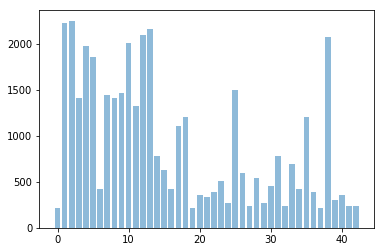

In [7]:
classes, dist = np.unique(y+yt, return_counts=True)
NUM_CLASSES = len(classes)
print ("No classes:{}".format(NUM_CLASSES))

plt.bar(classes, dist, align='center', alpha=0.5)
plt.show()

In [8]:
class_weight = {c:dist[c]/np.sum(dist) for c in classes}

## Running a classification task

In [9]:
batch_size = 256
tgen=ImageDataGenerator(rescale=1./255,
                        rotation_range=5,
                        width_shift_range=0.10, 
                        height_shift_range=0.10)

train_gen = tgen.flow(np.array(X), 
                      to_categorical(y), 
                      batch_size=batch_size)

In [10]:
vgen=ImageDataGenerator(rescale=1./255)

val_gen = vgen.flow(np.array(Xt), 
                    to_categorical(yt), 
                    batch_size=batch_size)

In [11]:
def small_cnn():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(64, (5, 5), activation='relu'))   
    model.add(Flatten())
    model.add(Dense(768, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model


model = small_cnn()
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(X) // batch_size,
                              validation_data=val_gen,
                              validation_steps=len(Xt) // batch_size,
                              class_weight=class_weight,
                              epochs=100, 
                              verbose=2)

Epoch 1/100


In [ ]:
print("Best validation accuracy: {:0.3f}"
       .format(np.max(history.history['val_acc'])))

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy'); plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()